In [1]:
import numpy as np

from betaburst.detection.burst_detection import TfBursts

from neurodsp.sim import sim_powerlaw
from neurodsp.utils import set_random_seed, create_times

import matplotlib.pyplot as plt



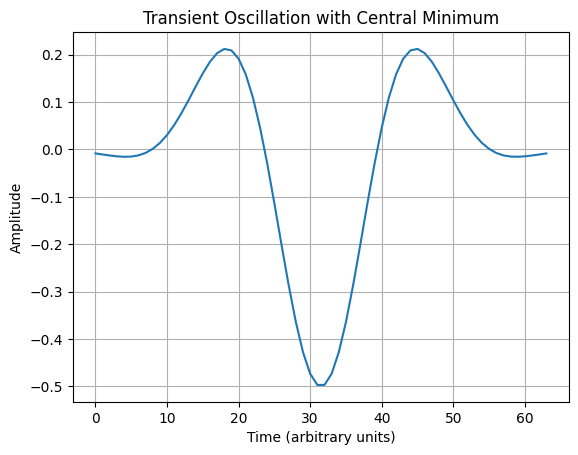

In [2]:
def generate_transient_minimum(w_size, freq=1, amplitude=0.5, decay=0.002):
    """
    Generate a transient oscillation with a clear local minimum at the center.
    
    Parameters:
        w_size (int): The size of the window (number of data points).
        freq (float): The frequency of the oscillation (controls how many oscillations occur).
        amplitude (float): The amplitude of the oscillation.
        decay (float): Decay factor for the transient effect.
        
    Returns:
        np.ndarray: Array containing the transient oscillation with a minimum at the center.
    """
    # Time vector centered around zero
    t = np.linspace(-1, 1, w_size)
    
    # Oscillatory part (inverted cosine wave) ensuring a minimum at the center
    oscillation = -amplitude * np.cos(2 * np.pi * freq * t)
    
    # Apply a Gaussian window to create the transient effect
    window = np.exp(-decay * (t * w_size) ** 2)
    
    # Combine the oscillation and the window
    transient_oscillation = oscillation * window
    
    return transient_oscillation

# Example usage
w_size = 64
signal = generate_transient_minimum(w_size, decay=0.001)

# Plot the result
plt.plot(signal)
plt.title("Transient Oscillation with Central Minimum")
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [3]:
np.random.seed(42) # Reproducibility

# Simulation settings
fs = 250
n_epochs = 100
n_seconds = n_epochs*2*5
exponent = -1
sig = sim_powerlaw(n_seconds, fs, exponent, f_range=(1, None))
times = create_times(n_seconds, fs)
epochs = sig.reshape((n_epochs, 2, 5*fs)) /5   # MNE format: (epoch, channel, trial)

# epochs = np.random.randn(n_epochs, 2, 5*fs) / 10

print(np.max(epochs))
print(np.min(epochs))
f_stim = 15
length = 0.16
w_size = int(length*fs)
t = np.arange(0, length, 1/fs)

for epochs_idx in range(n_epochs):
    for _ in range(3):
        coin = np.random.binomial(1, p=0.95)
        loc = np.random.uniform(0, 5-length)
        if coin > 0:
            decay = np.random.uniform(0.001, 0.008)
            epochs[epochs_idx, 0, int(loc*fs):int((loc+length)*fs)] =  7*generate_transient_minimum(w_size, decay=decay)
        else:
            std_stim = np.random.uniform(-5, 10)
            epochs[epochs_idx, 0, int(loc*fs):int((loc+length)*fs)] = 2*np.sin(2*np.pi*t*(f_stim + std_stim))

# epochs[0, 0, int(1*fs):int((1+length)*fs)] =  7*generate_transient_minimum(w_size, decay=0.00001) 
# epochs[0, 0, int(3*fs):int((3+length)*fs)] =  7*generate_transient_minimum(w_size,  decay=0.002)
# epochs[2, 0, int(3.5*fs):int((3.5+length)*fs)] =  7*generate_transient_minimum(w_size,  decay=0.001)
# epochs[4, 0, int(1.5*fs):int((1.5+length)*fs)] =  7*generate_transient_minimum(w_size, decay=0.00001)
# epochs[8, 0, int(4*fs):int((4+length)*fs)] =  7*generate_transient_minimum(w_size,  decay=0.002)

# epochs[1, 0, int(1*fs):int((1+length)*fs)] =  2*np.sin(2*np.pi*t*f_stim)
# epochs[3, 0, int(2*fs):int((2+length)*fs)] =  2*np.sin(2*np.pi*t*(f_stim+4))
# epochs[5, 0, int(3.5*fs):int((3.5+length)*fs)] += 2*np.sin(2*np.pi*t*(f_stim+4))
# epochs[9, 0, int(1*fs):int((1+length)*fs)] =  2*np.sin(2*np.pi*t*(f_stim+7))
# epochs[9, 0, int(3*fs):int((3+length)*fs)] = 2*np.sin(2*np.pi*t*f_stim)



0.8683103060760777
-0.9781678649487408


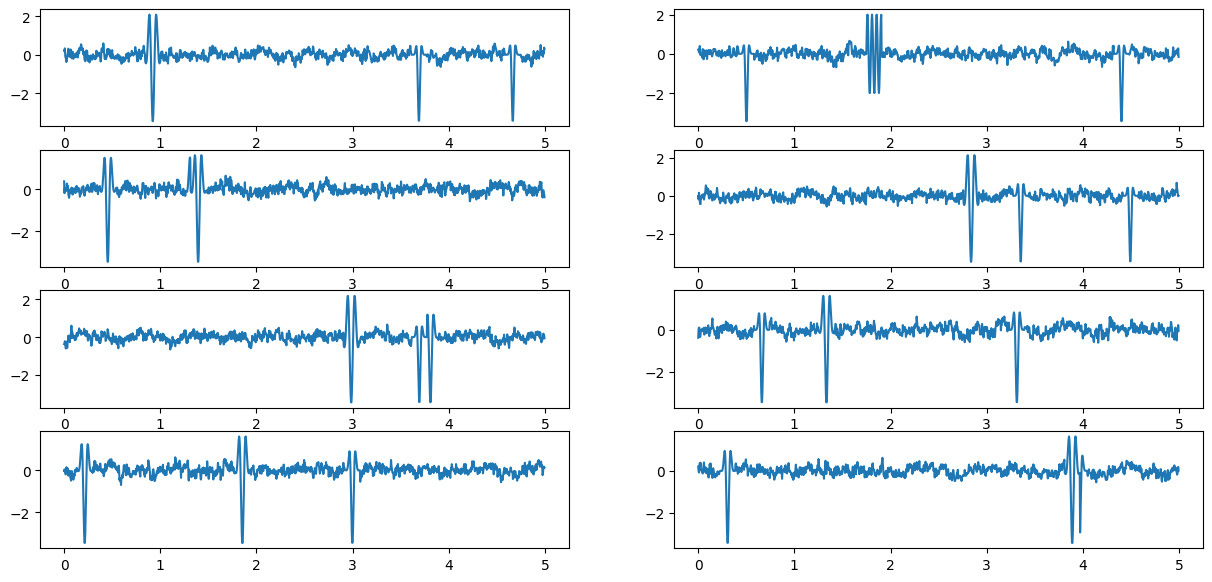

In [4]:
plt.figure(figsize=(15,7))
plt.subplot(4,2,1)
plt.plot(np.arange(0, 5, 1/fs), epochs[0,0,:])
plt.subplot(4,2,2)
plt.plot(np.arange(0, 5, 1/fs), epochs[4,0,:])
plt.subplot(4,2,3)
plt.plot(np.arange(0, 5, 1/fs), epochs[2,0,:])
plt.subplot(4,2,4)
plt.plot(np.arange(0, 5, 1/fs), epochs[8,0,:])


plt.subplot(4,2,5)
plt.plot(np.arange(0, 5, 1/fs), epochs[1,0,:])
plt.subplot(4,2,6)
plt.plot(np.arange(0, 5, 1/fs), epochs[5,0,:])
plt.subplot(4,2,7)
plt.plot(np.arange(0, 5, 1/fs), epochs[3,0,:])
plt.subplot(4,2,8)
plt.plot(np.arange(0, 5, 1/fs), epochs[9,0,:])

In [5]:
freq_step = 0.5
freqs = np.arange(5.0, 47.0, freq_step)
upto_gamma_band = np.array([8, 40])
upto_gamma_range = np.where(
    np.logical_and(freqs >= upto_gamma_band[0], freqs <= upto_gamma_band[1])
)[0]

bm =  TfBursts(
        fs,
        freqs = freqs,
        fr_band = upto_gamma_band,
        band_search_range = upto_gamma_range,
        band_limits=[8, 10, 35],
        remove_fooof=False,
    )

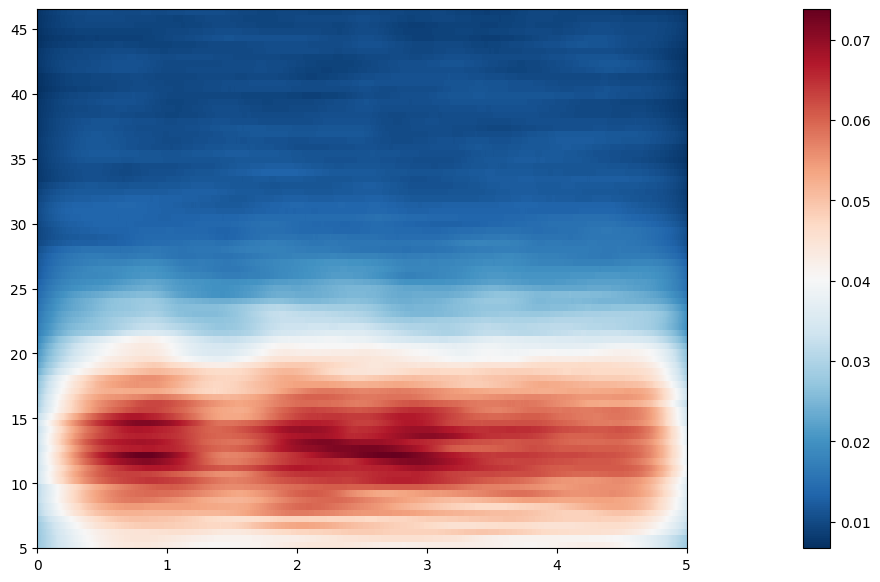

In [6]:
tfs = bm._apply_tf(epochs)
av_psds = np.mean(
             tfs, axis=0
        )
plt.figure(figsize=(30,7))
plt.imshow(av_psds[0,:,:],  aspect=1/10, cmap="RdBu_r", interpolation="none", origin="lower", extent=[0, epochs.shape[2]/fs,  freqs[0], freqs[-1]])
plt.colorbar()

In [7]:
bursts = bm.burst_extraction(epochs, band="beta", std_noise=4)

Initiating beta band burst extraction without aperiodic activity subtraction...
	Burst extraction for all channels: from 10 to 35 Hz.


In [8]:
bursts[0].keys()

dict_keys(['channel', 'trial', 'waveform', 'peak_freq', 'peak_amp_iter', 'peak_amp_base', 'peak_time', 'peak_adjustment', 'fwhm_freq', 'fwhm_time', 'polarity', 'volume', 'waveform_times'])

In [9]:
print(len(np.sort((bursts[0]['peak_amp_iter']))))
bigger = np.argsort(bursts[0]['peak_amp_iter'])[::-1][:30]
print(bursts[0]['peak_time'][bigger])
print(bursts[0]['trial'][bigger])
# print(np.sort(bursts[1]['peak_time']))


2343
[2.466 0.893 0.781 0.889 0.893 0.785 2.054 2.478 0.801 1.221 0.765 0.749
 3.839 2.038 1.325 1.117 2.914 2.574 2.142 0.849 4.359 0.733 4.219 2.922
 2.886 2.274 4.66  3.026 1.833 0.292]
[29 83 26 64 64 26 99 29 11 93 19 19 98 99 46 93  8 18 70 11 47 63 81 20
 32 36 32  1  4 41]


2346


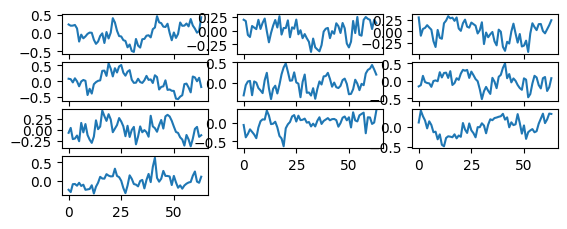

In [10]:
nb_bursts = len(bursts[1]['waveform'])
print(nb_bursts)
bigger_ch2 = np.argsort(bursts[1]['peak_amp_iter'])[::-1][:10]
for idx, burst in enumerate(bursts[1]['waveform'][bigger_ch2]):
    plt.subplot(8,3,idx+1)
    plt.plot(burst)

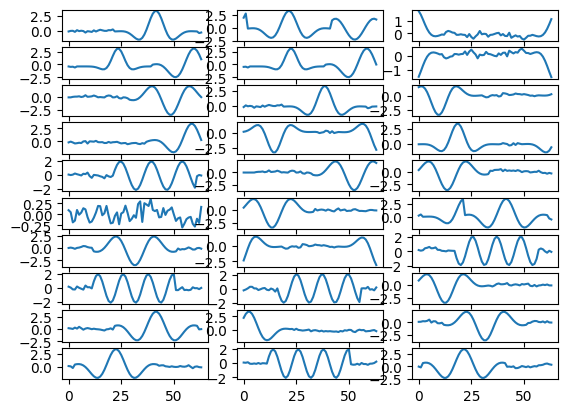

In [11]:
nb_bursts = len(bursts[0]['waveform'])
for idx, burst in enumerate(bursts[0]['waveform'][bigger]):
    plt.subplot(10,3,idx+1)
    plt.plot(burst)

## Waveforms shape analysis

In [12]:
from betaburst.analysis.burst_analysis import BurstSpace

bs = BurstSpace(perc=0.5, nb_quartiles=10, tmin = 0, tmax = 5, time_step = 0.2)

In [61]:
scores_dists = bs.fit_transform(bursts)
bs.plot_waveforms()

Concatenating bursts along the different channels...


AttributeError: 'BurstSpace' object has no attribute 'plot_waveforms'

In [53]:
nb_quartiles = 10

In [59]:
# Estimation of waveforms and modulation index per component.
comps_groups = 10
bin_dt = 0.2
tmin = 0
tmax = 5

binning = np.arange(tmin, tmax + bin_dt, bin_dt)

modulation_index = np.empty((bs.components.shape[1], comps_groups, len(binning)-1))
comp_waveforms =  np.empty((bs.scores_dists.shape[1], comps_groups, np.array(bs.burst_dict["waveform"]).shape[-1]))

assert comps_groups > 1, "You need to specify at least 2 groups."
for idx_compo in range(bs.components.shape[1]):
    current_compo = bs.components[idx_compo, :]
    # Divide waveforms in comps_groups along
    iqrs = np.linspace(np.min(current_compo), np.max(current_compo), comps_groups + 1)

    for idx_group in range(comps_groups):
        # Group score limits.
        scores_lims = [iqrs[idx_group], iqrs[idx_group + 1]]

        # Condition specific waveforms.
        if idx_group != comps_groups - 1:
            waveform_ids = np.where(
                (scd >= scores_lims[0]) & (scd < scores_lims[1])
            )[0]
        else:
            waveform_ids = np.where(scd >= scores_lims[0])[0]
        waveform = np.mean(np.array(bs.burst_dict["waveform"])[waveform_ids], axis=0)
        selected_peak_time = np.array(bs.burst_dict["peak_time"])[waveform_ids]
        hist, _ = np.histogram(selected_peak_time, bins=binning)
        modulation_index[idx_compo, idx_group, :] = hist
        comp_waveforms[idx_compo, idx_group, :] = waveform

c:\Users\ludov\.conda\envs\embed\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ludov\.conda\envs\embed\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


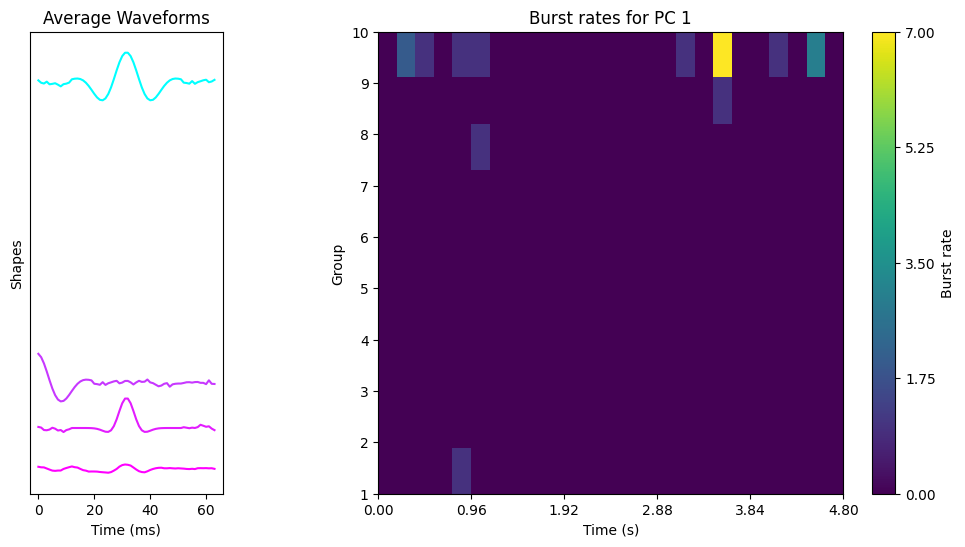

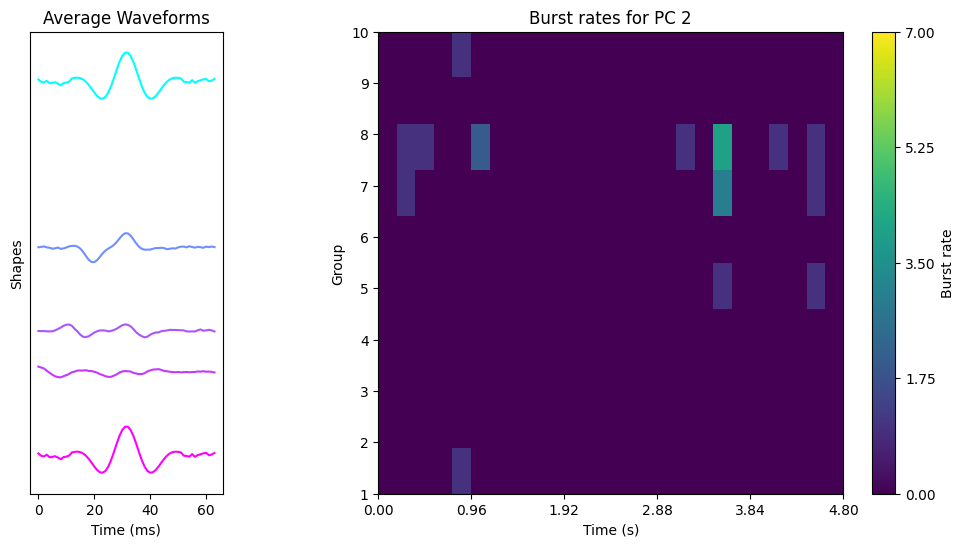

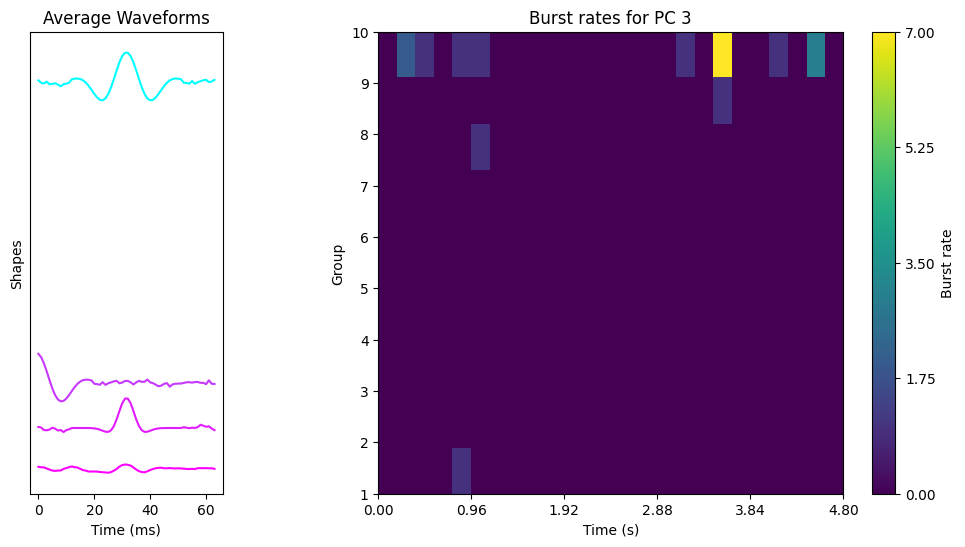

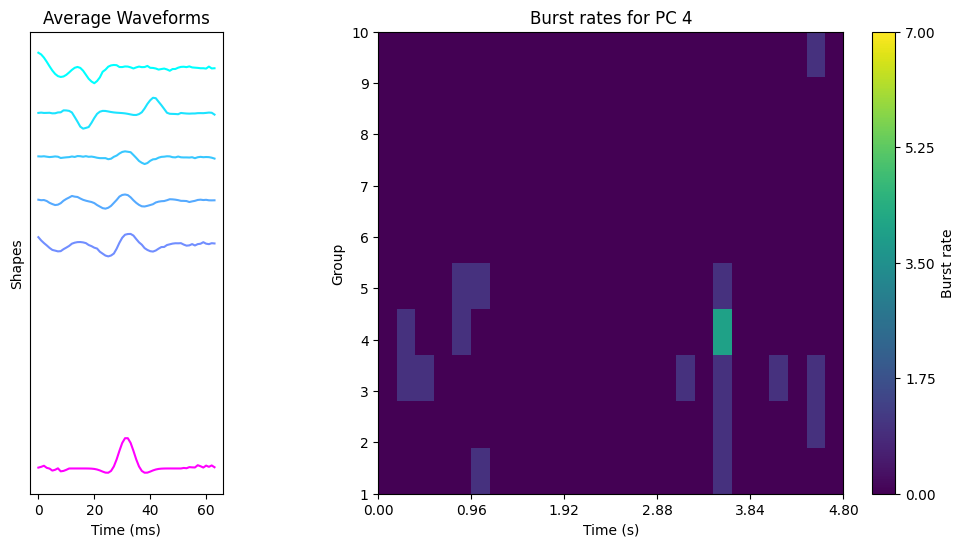

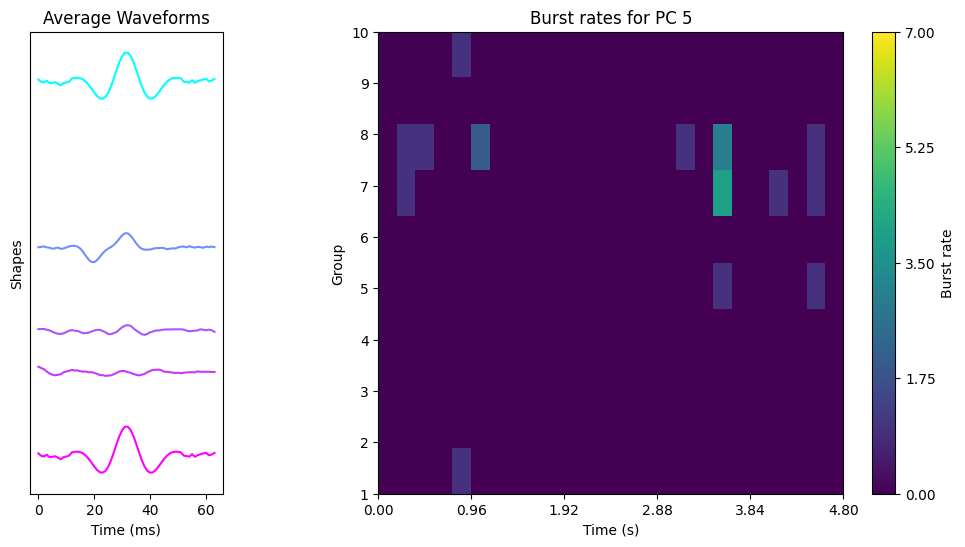

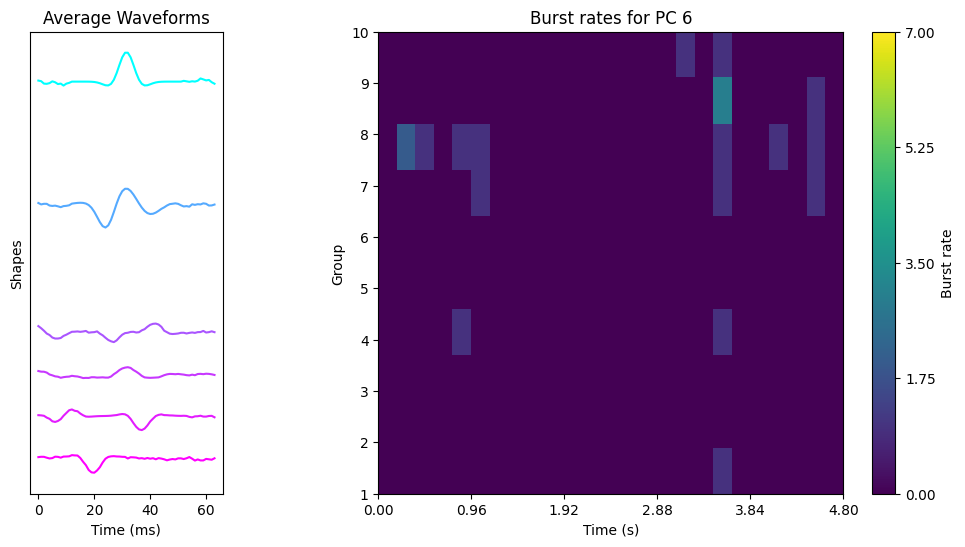

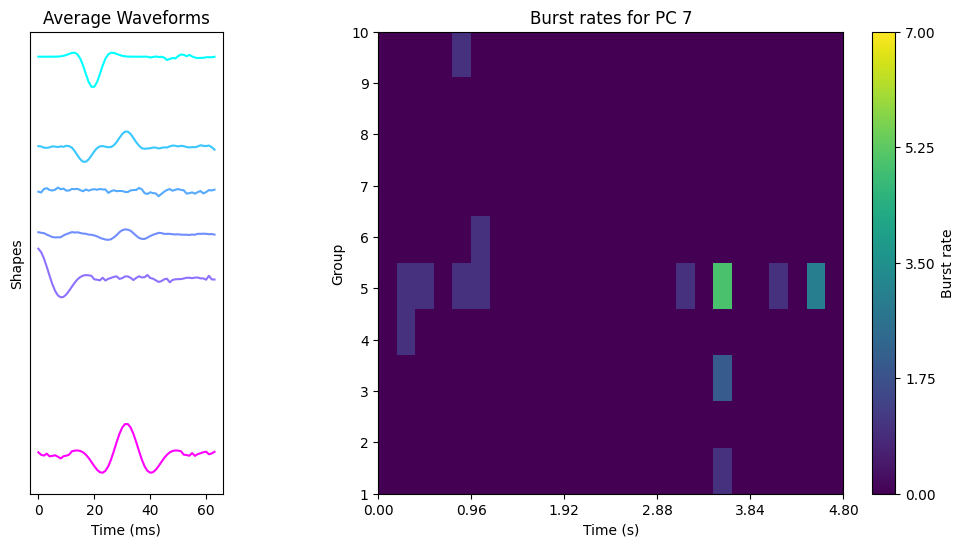

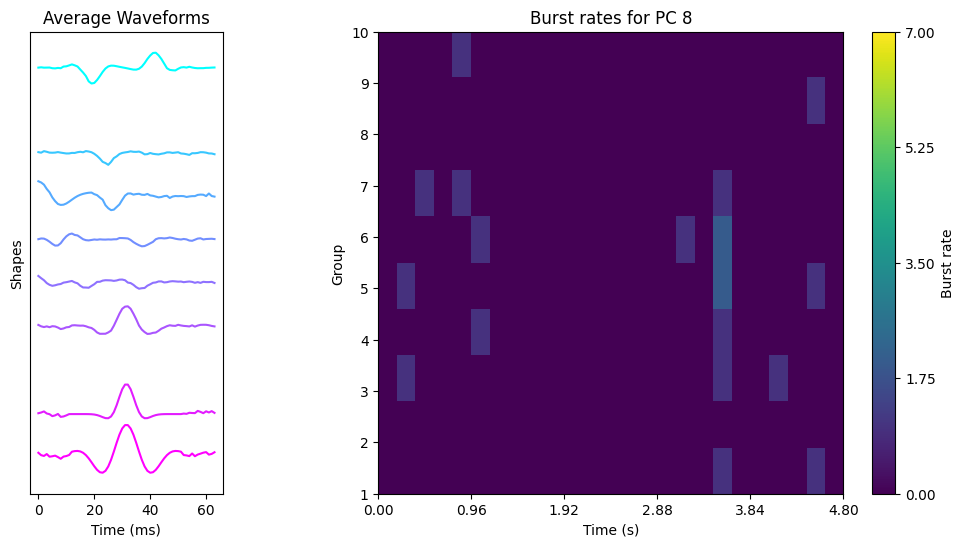

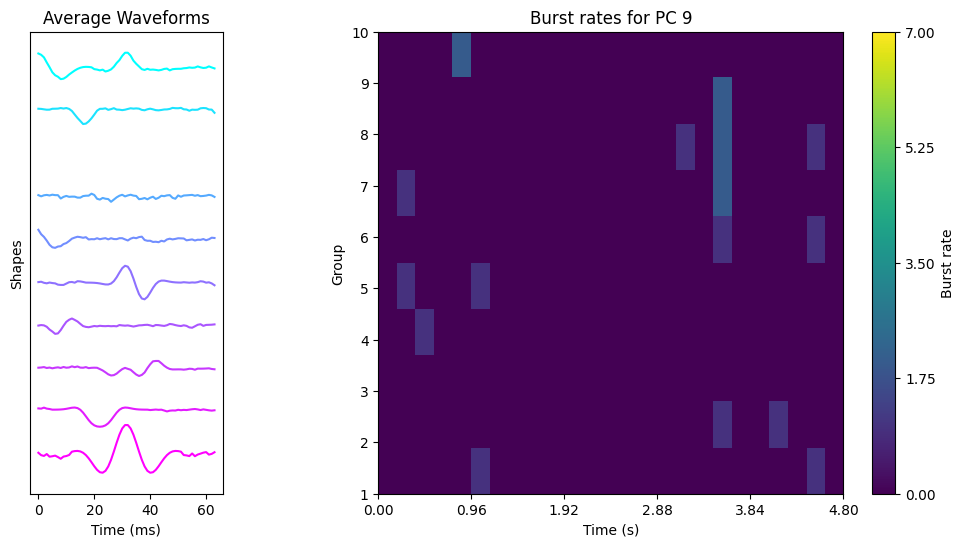

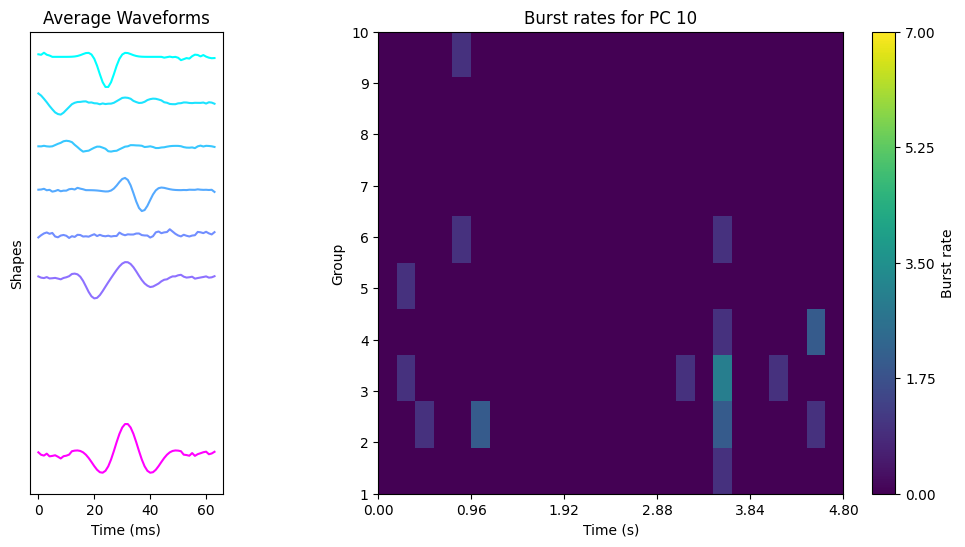

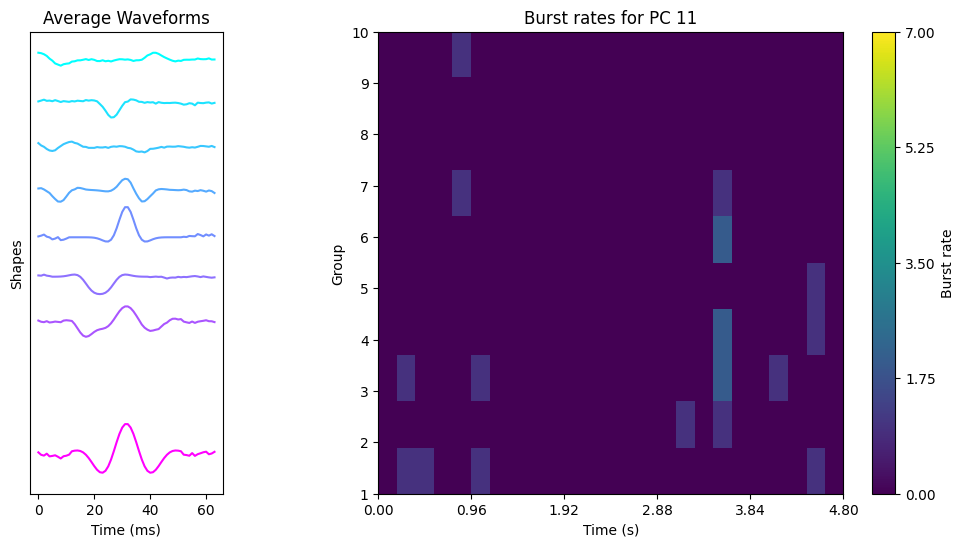

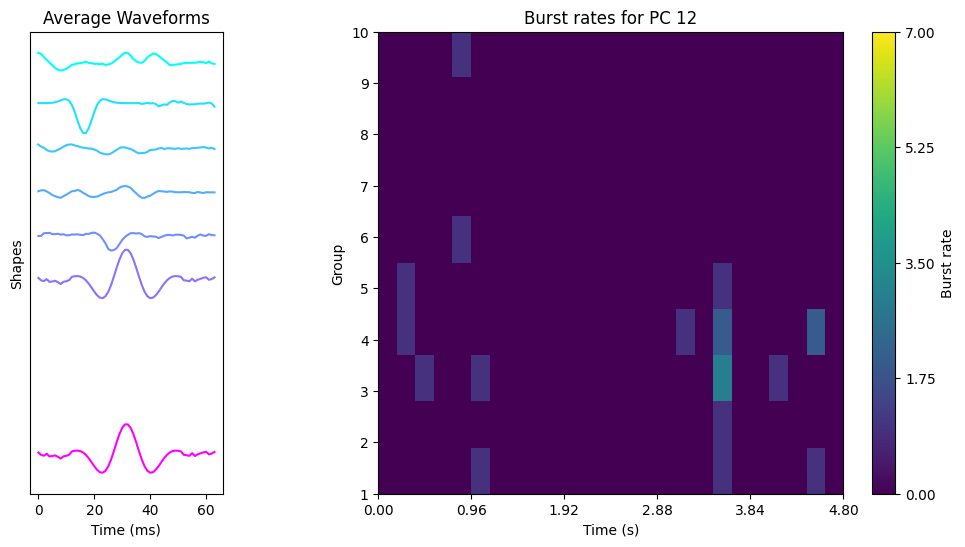

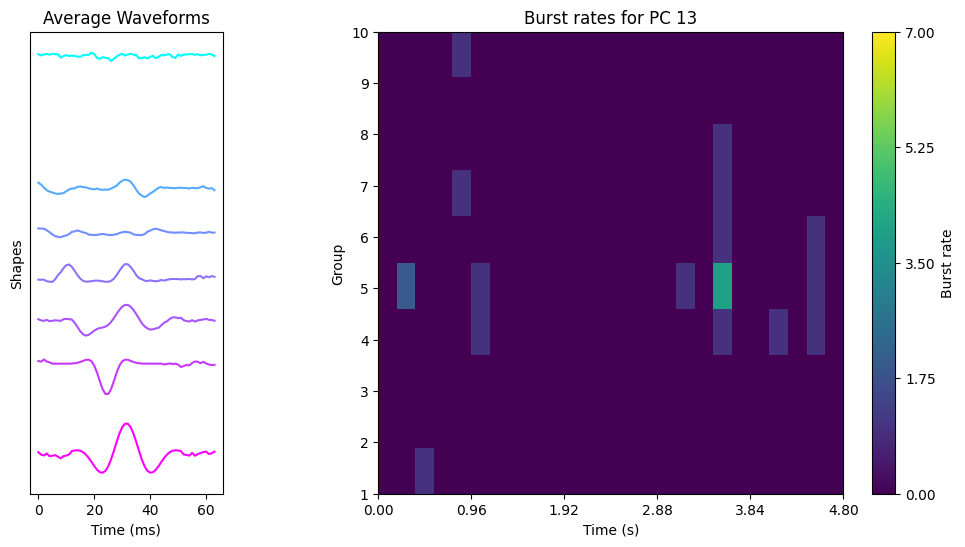

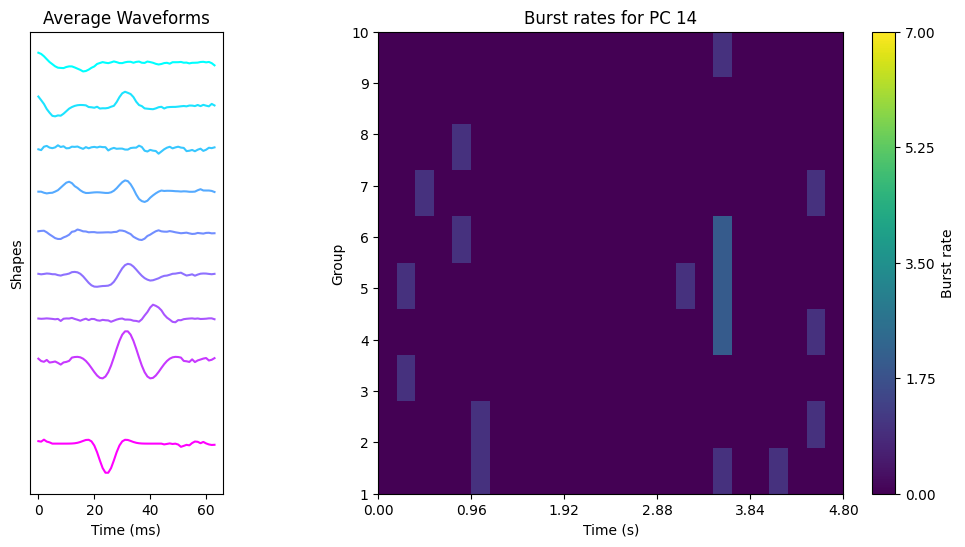

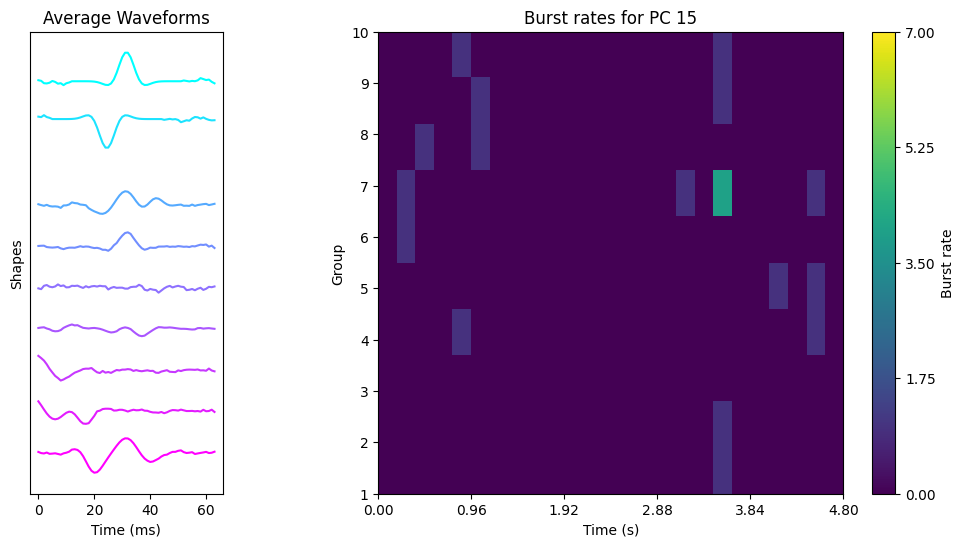

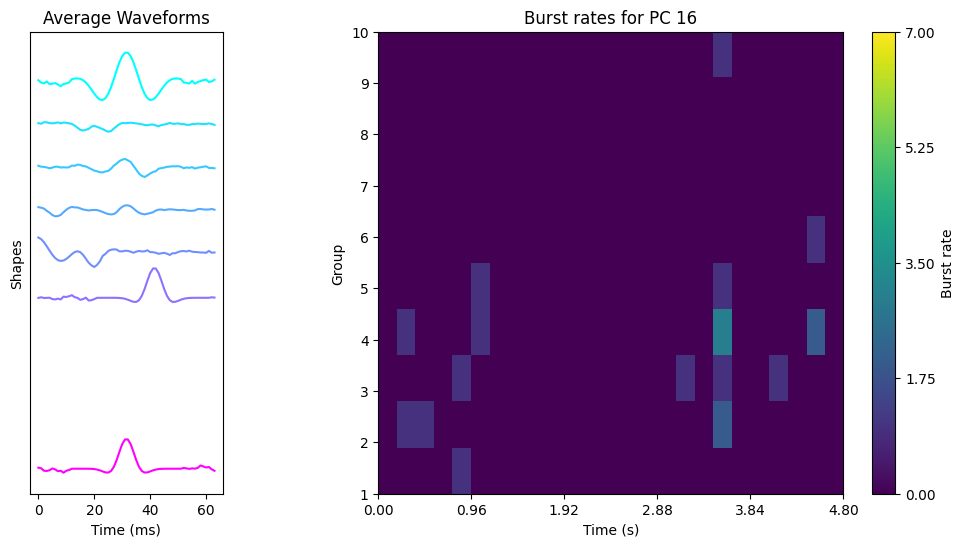

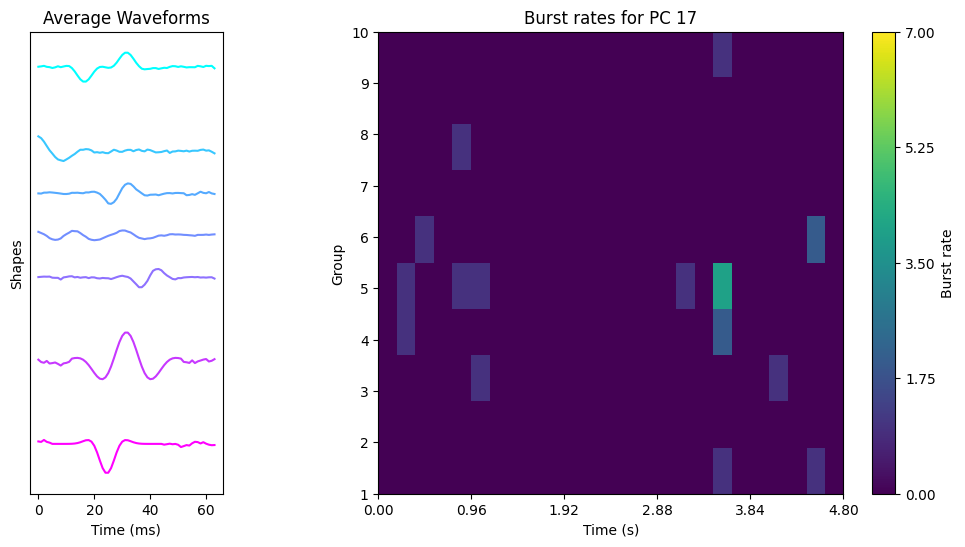

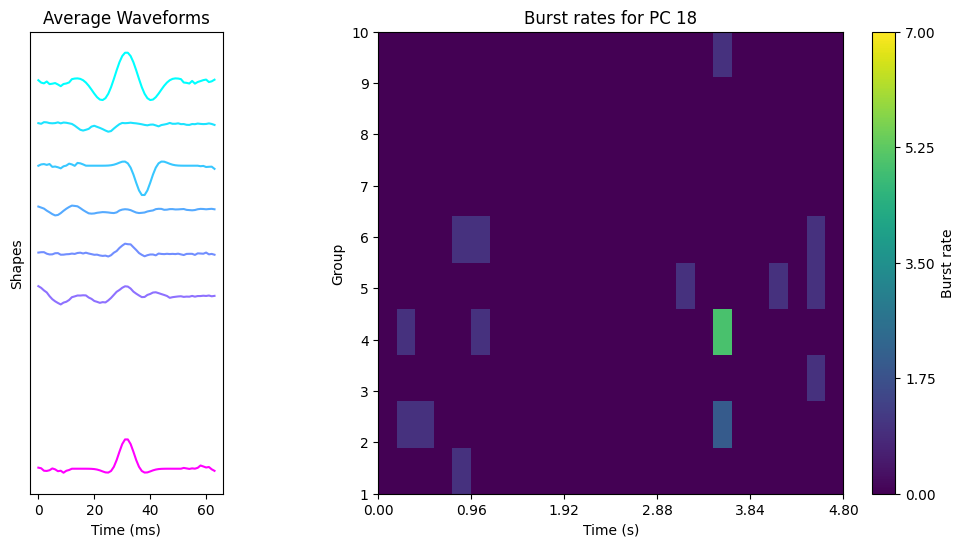

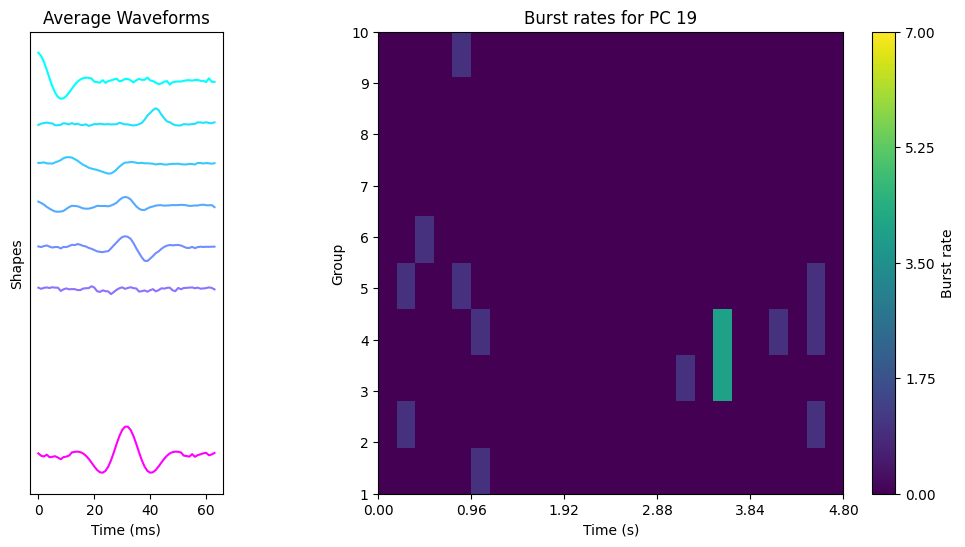

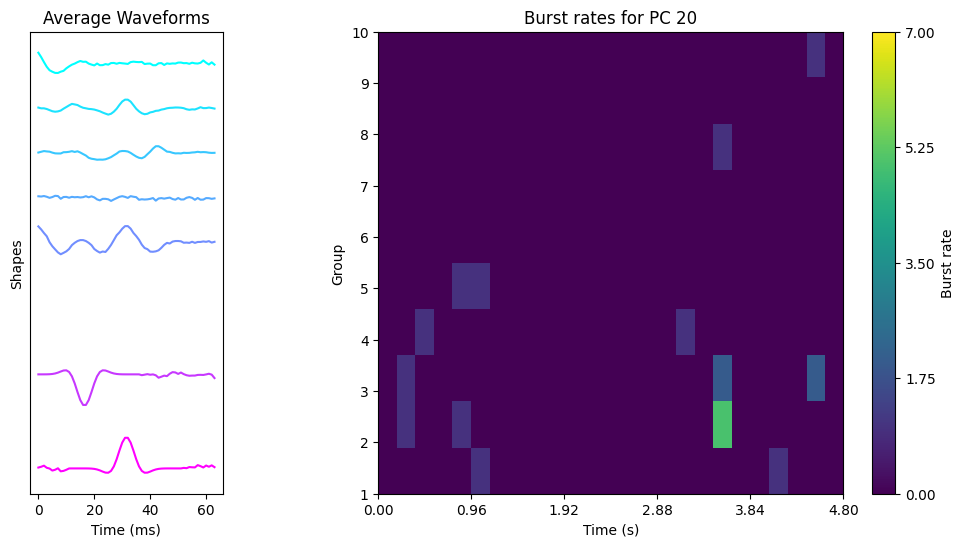

In [69]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

vmin = np.min(modulation_index)
vmax = np.max(modulation_index)
x_axis = binning[:-1]  # Exclude the last element to match modulation_index shape
y_axis = np.arange(modulation_index.shape[1])  # Index range for comps_groups


# Define the colormap for the waveforms
quartiles = np.arange(comps_groups)
colors = plt.cm.cool(np.linspace(0, 1, num=len(quartiles)))

# Define an offset to spread the waveforms
waveform_offset = 5  # This can be adjusted depending on your data

for i in range(modulation_index.shape[0]):  # Iterate over the first dimension of modulation_index
    # Create a figure with a specific grid layout
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3], wspace=0.4)  # Adjust width_ratios and wspace

    # Left subplot for the waveforms
    ax_waveform = fig.add_subplot(gs[0])
    for j in range(comps_groups):
        # Apply an offset to spread out the waveforms vertically
        ax_waveform.plot(comp_waveforms[i, j, :] + j * waveform_offset, color=colors[j], label=f'Group {j+1}')
    
    ax_waveform.set_title('Average Waveforms')
    ax_waveform.set_xlabel('Time (ms)')
    ax_waveform.set_ylabel('Shapes')
    
    # Invert y-axis to match the heatmap orientation
    ax_waveform.invert_yaxis()

    # Remove y-ticks as they are not directly comparable to the heatmap
    ax_waveform.set_yticks([])

    # Right subplot for the heatmap
    ax_heatmap = fig.add_subplot(gs[1])
    heatmap = ax_heatmap.imshow(modulation_index[i, :, :], aspect='auto',
                                extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]],
                                origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    
    ax_heatmap.set_xlabel('Time (s)')
    ax_heatmap.set_ylabel('Group')
    ax_heatmap.set_title(f'Burst rates for PC {i+1}')
    
    ax_heatmap.set_xticks(np.linspace(x_axis[0], x_axis[-1], num=int(len(x_axis)/4)))
    ax_heatmap.set_yticks(np.linspace(y_axis[0], y_axis[-1], num=len(y_axis)))
    ax_heatmap.set_yticklabels(range(1, comps_groups + 1))  # Match group labels

    fig.colorbar(heatmap, ax=ax_heatmap, label='Burst rate', ticks=np.linspace(vmin, vmax, num=5))

    plt.show()


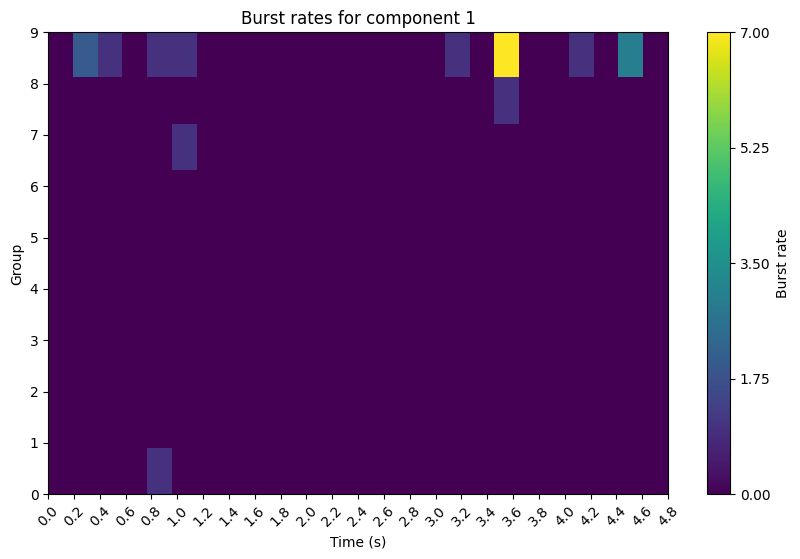

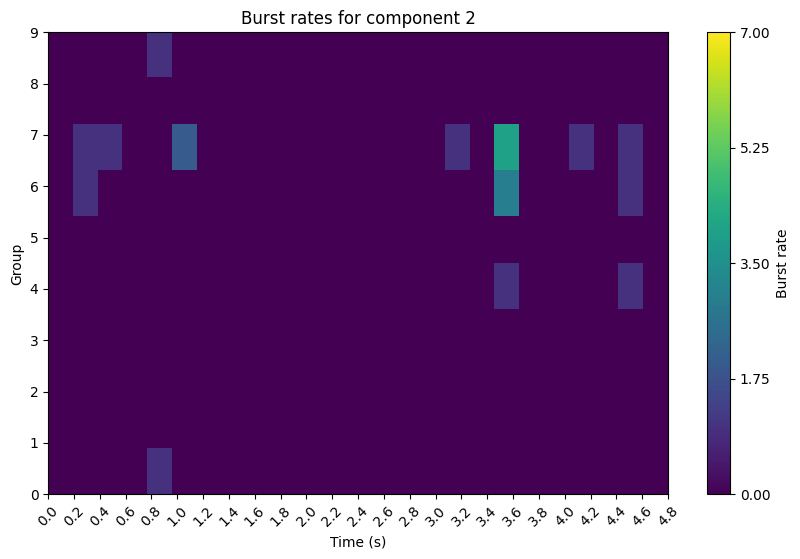

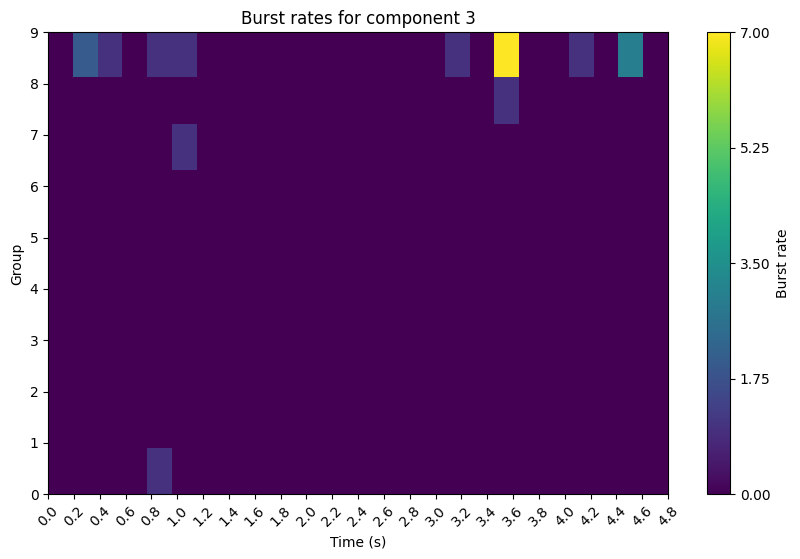

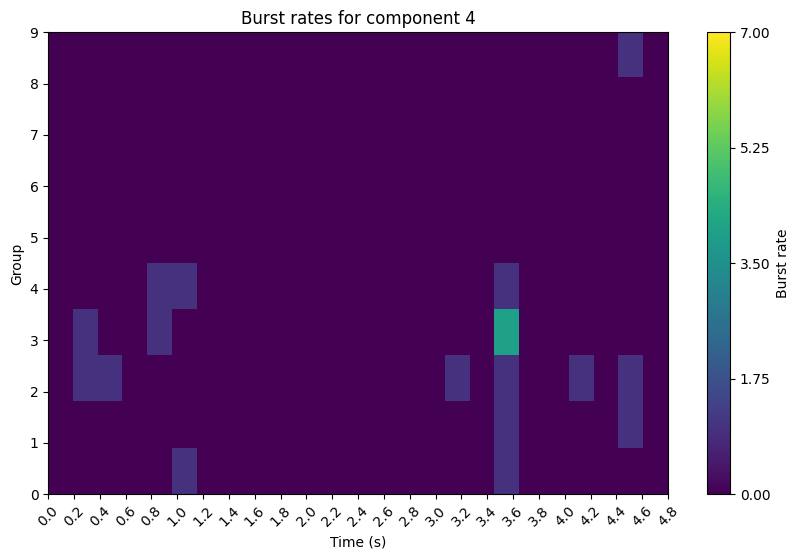

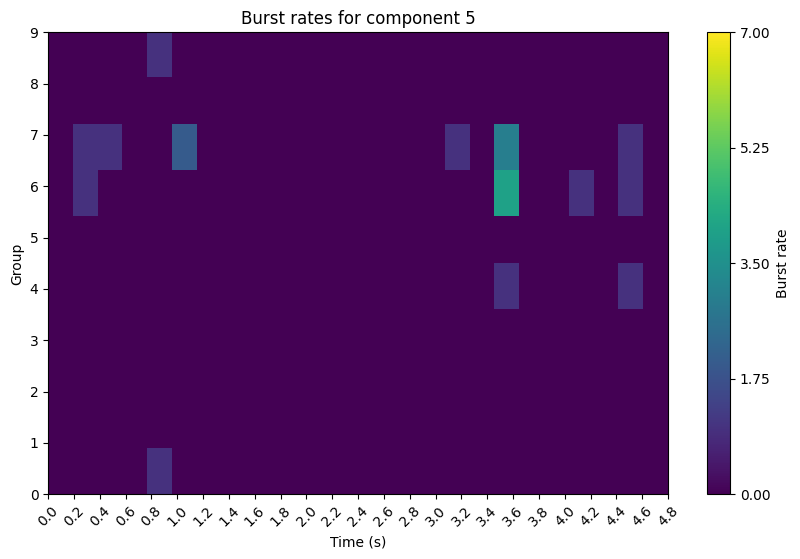

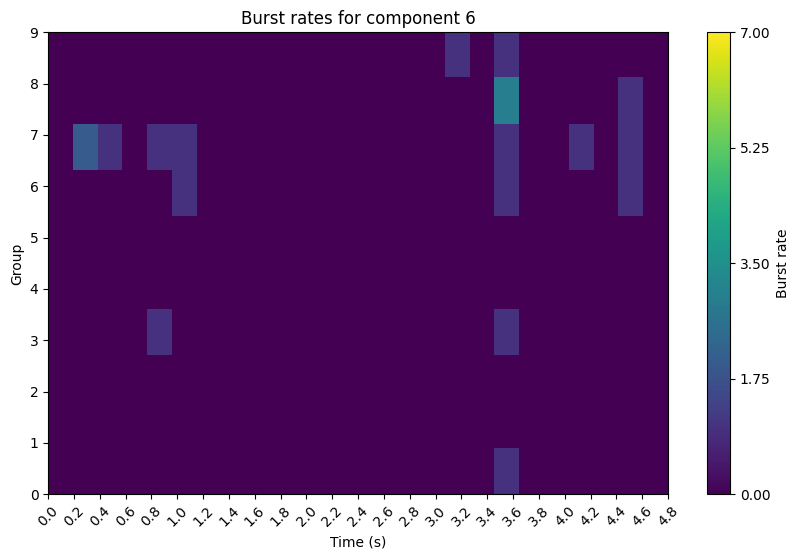

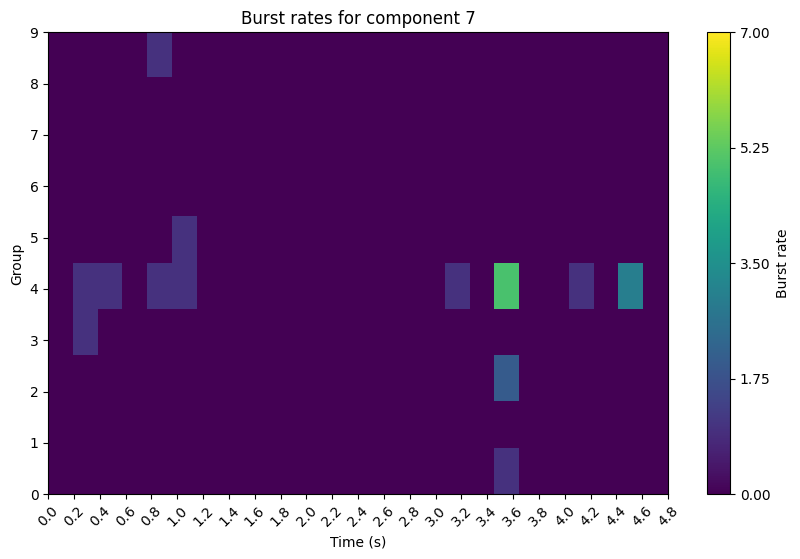

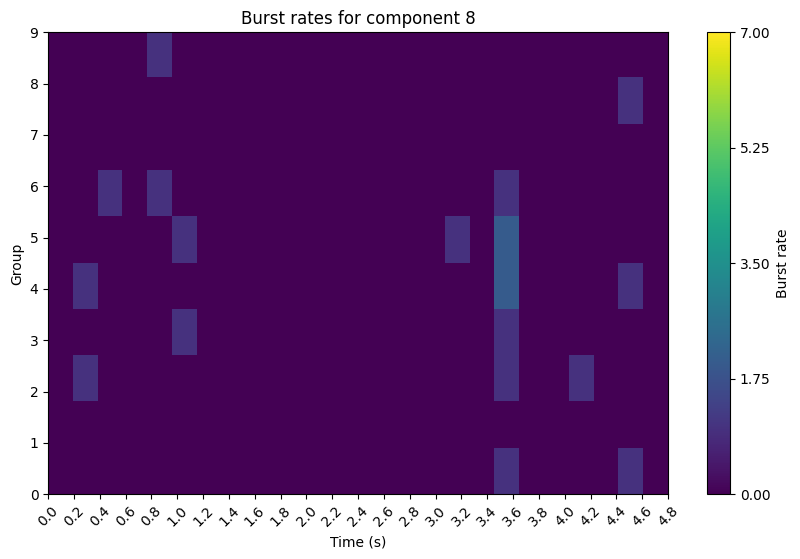

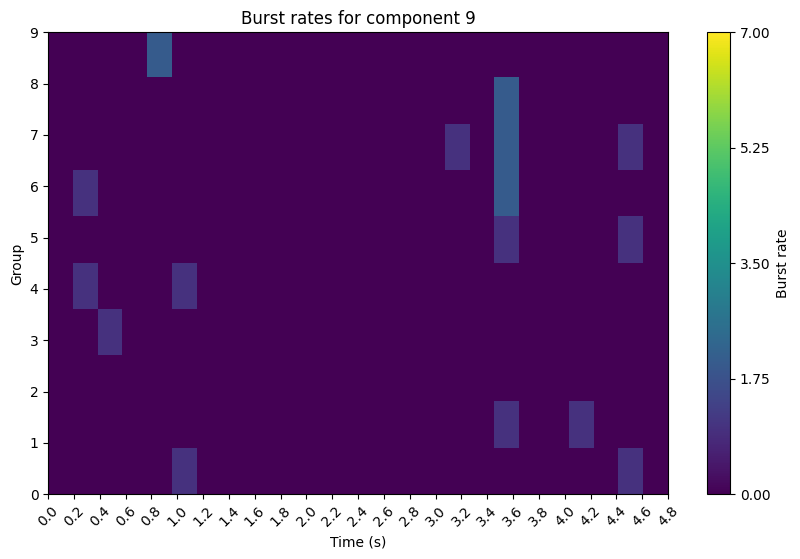

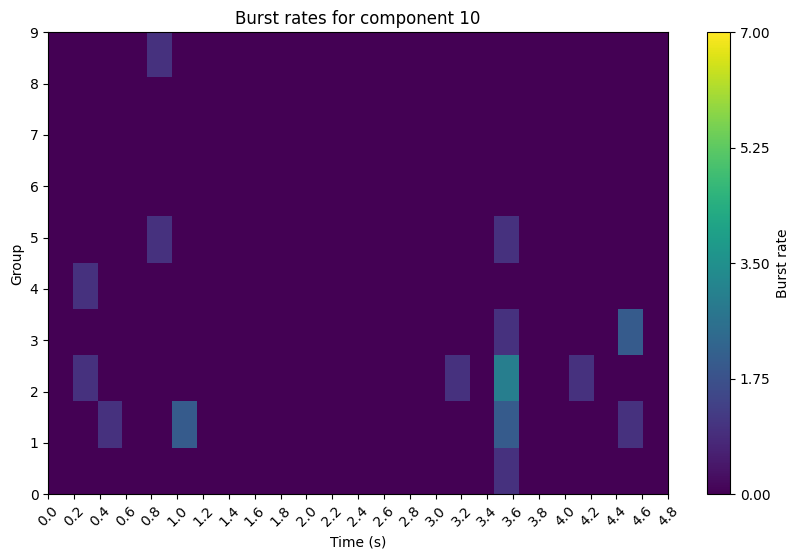

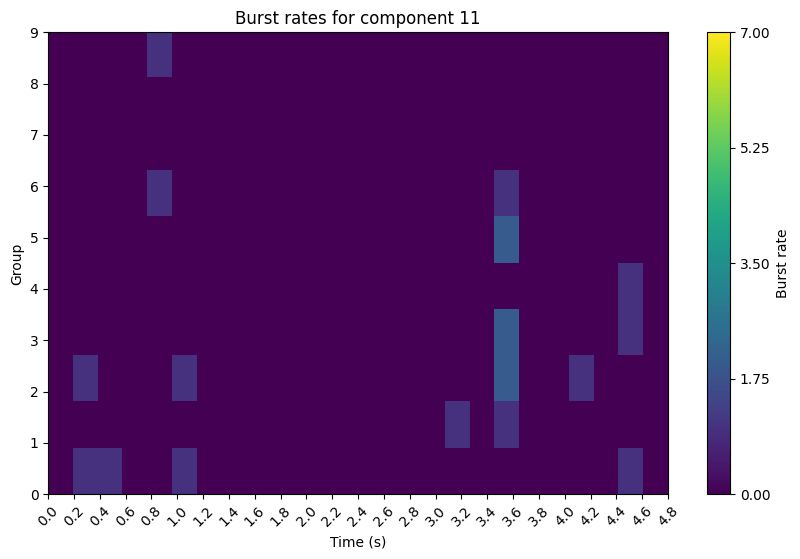

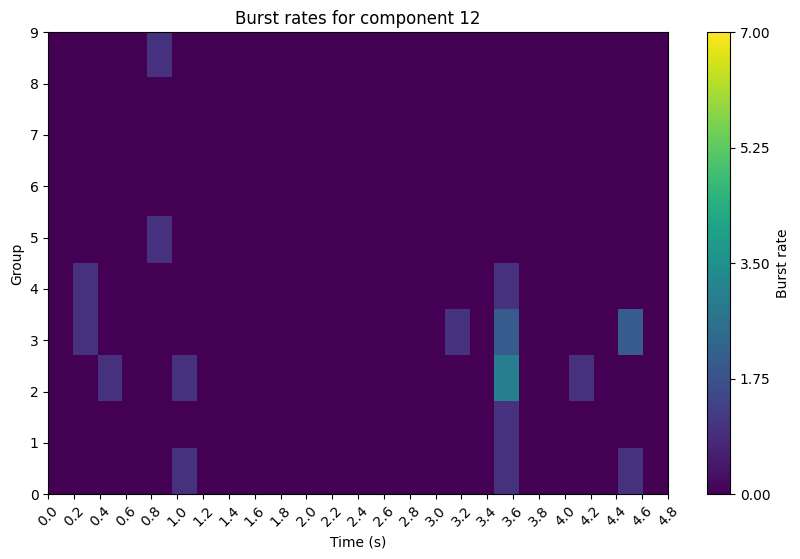

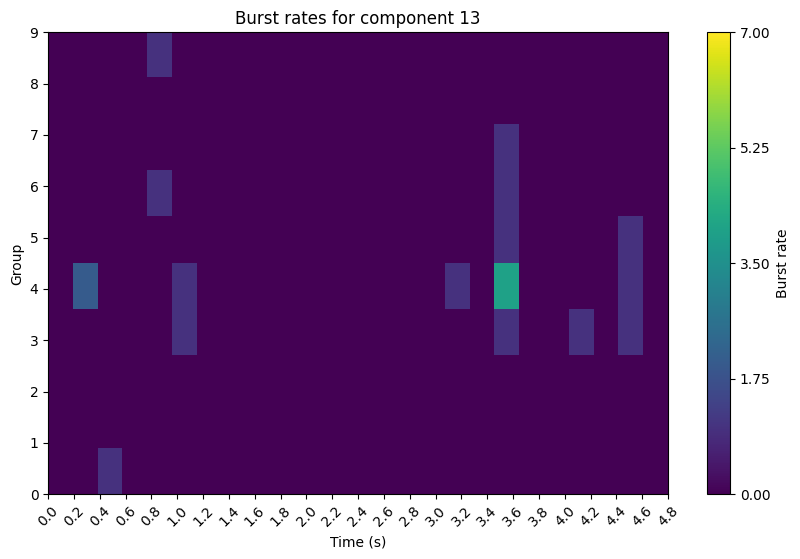

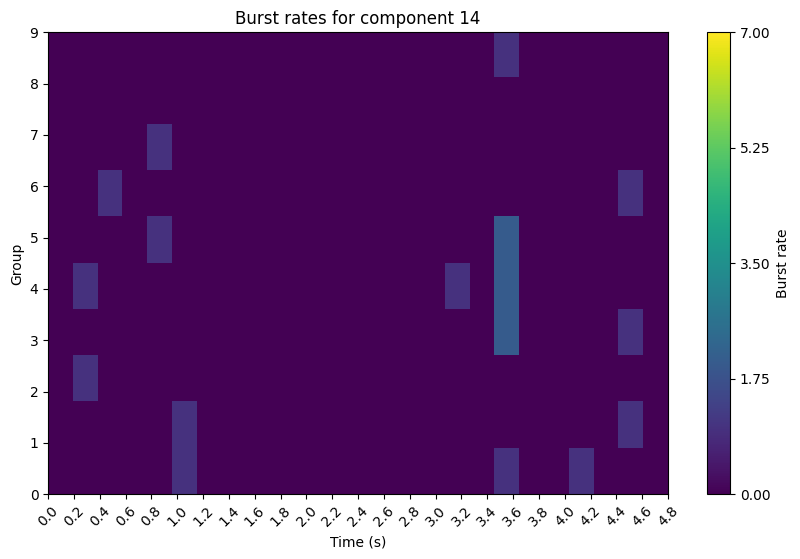

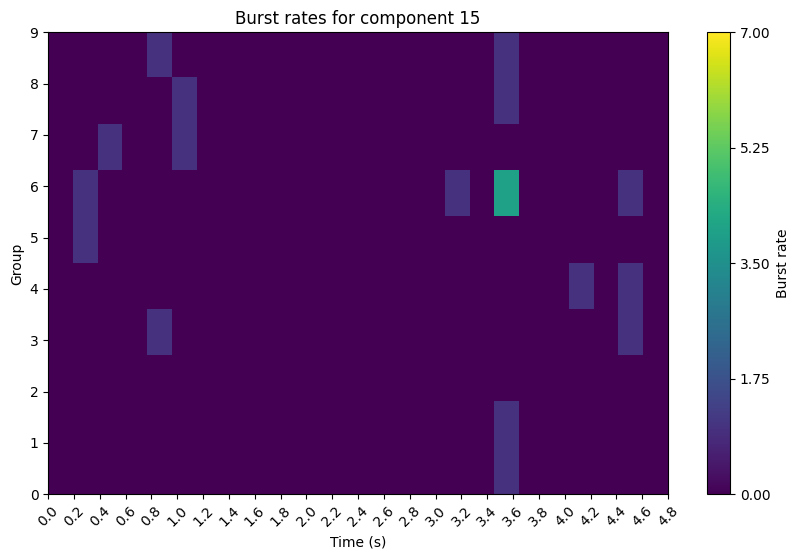

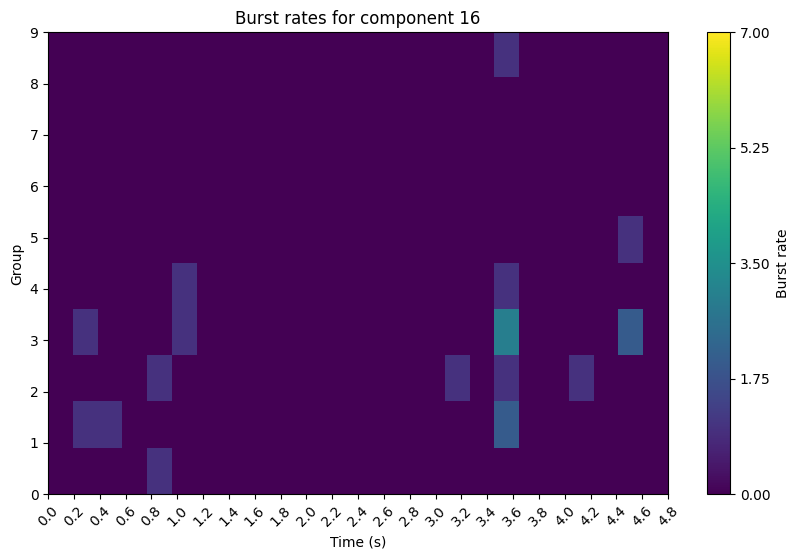

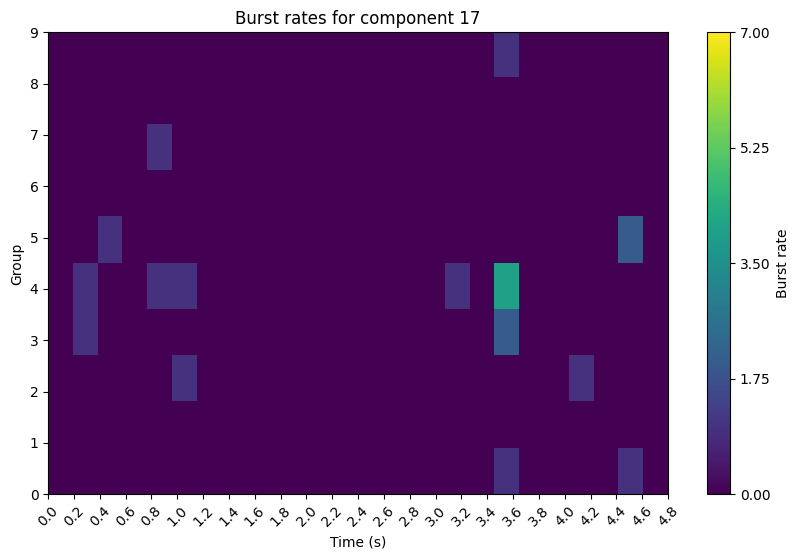

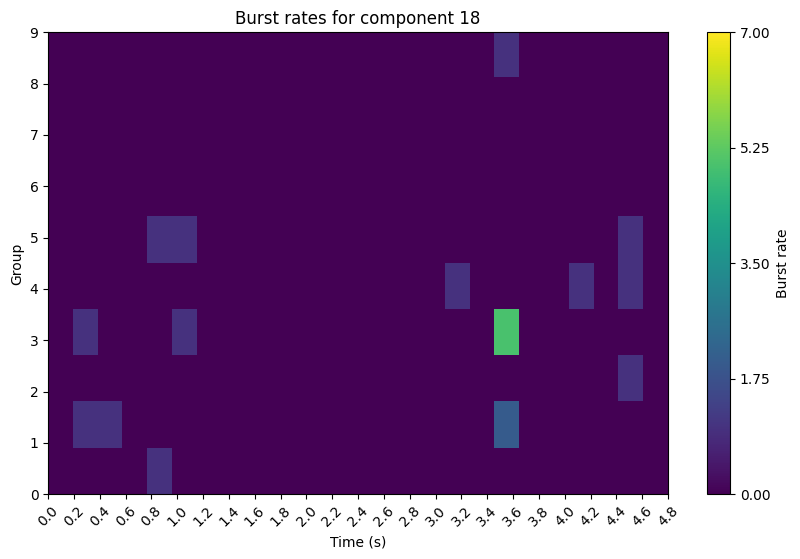

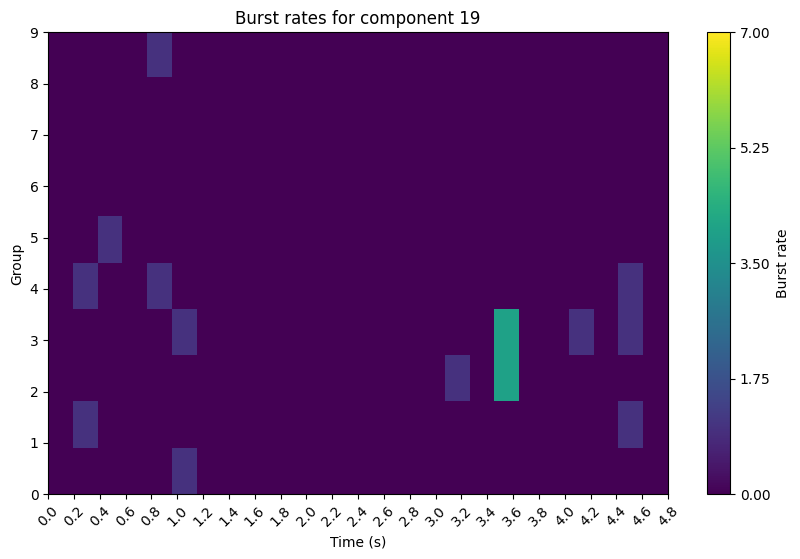

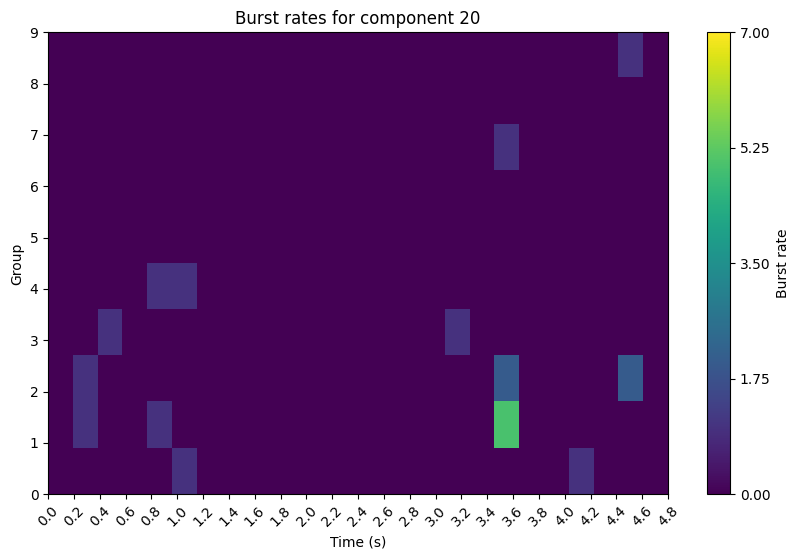

In [60]:
vmin = np.min(modulation_index)
vmax = np.max(modulation_index)

# Define the x-axis and y-axis
x_axis = binning[:-1]  # Exclude the last element to match modulation_index shape
y_axis = np.arange(modulation_index.shape[1])  # Index range for comps_groups

# Plot each modulation index slice
for i in range(modulation_index.shape[0]):  # Iterate over the first dimension of modulation_index
    plt.figure(figsize=(10, 6))
    
    # Plot the heatmap with fixed color limits
    plt.imshow(modulation_index[i, :, :], aspect='auto',
               extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]],
               origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)

    # Set x and y labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Group')
    plt.title(f'Burst rates for PC {i+1}')
    
    # Set the ticks on x and y axes
    plt.xticks(np.linspace(x_axis[0], x_axis[-1], num=len(x_axis)), rotation=45)
    plt.yticks(np.linspace(y_axis[0], y_axis[-1], num=len(y_axis)), labels=range(len(y_axis)))

    # Add colorbar with the same range for all plots
    plt.colorbar(label='Burst rate', ticks=np.linspace(vmin, vmax, num=5))
